## Imports

In [1]:
import numpy as np
import pickle
import os
from MyDataset import MyDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import functional as F
from tqdm.auto import tqdm
%matplotlib inline

## Transform raw data

In [2]:
pre_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomCrop(200),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

## Load Data

In [3]:
train_dataset = MyDataset("./train",pre_transform)
val_dataset = MyDataset("./validate",val_transform)

In [4]:
print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


## Visualize Traning Data

In [5]:
# img,label = train_dataset[0]
# if (label == 0):
#     print("This is class nil")
# elif (label == 1):
#     print("This is class MOD")
# else:
#     print("This is class SEV")

# Band8 = img[0][:][:]
# Band12 = img[1][:][:]
# Band13 = img[2][:][:]
# Band14 = img[3][:][:]
# Band = [Band8,Band12,Band13,Band14]

# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.imshow(Band[i-1])
# plt.show()

## Dataset statistic

In [6]:
# #Calculate the number of samples in differnet class
# train_nil_count = 0   ##591
# train_MOD_count = 0   ##839
# train_SEV_count = 0   ##324
# valid_nil_count = 0   ##192
# valid_MOD_count = 0   ##81
# valid_SEV_count = 0   ##33

# for i in range (0,1754):
#     #print(i)
#     img, label = train_dataset[i]
#     if (label == 0):
#         train_nil_count += 1
#     elif (label == 1):
#         train_MOD_count += 1
#     else:
#         train_SEV_count += 1
# print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))

# for i in range (0,306):
#     #print(i)
#     img, label = val_dataset[i]
#     if (label == 0):
#         valid_nil_count += 1
#     elif (label == 1):
#         valid_MOD_count += 1
#     else:
#         valid_SEV_count += 1
# print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

## Define Model

In [7]:
# class Blockconv2d(nn.Module):
#     def __init__(self, insize, outsize, kernel_size = 1, stride = 1, padding = 0):
#         super(Blockconv2d, self).__init__()
        
#         self.conv1 = nn.Conv2d(insize, insize, kernel_size, stride, padding)
#         self.conv2 = nn.Conv2d(insize, outsize, kernel_size = 1, stride = 1, padding = 0)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         return x

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(100352, 128)
        self.fc2 = nn.Linear(128, 3)
    
    def forward(self, x):
        # x's shape = N * 4 * 224 * 224, where N is batch size
        x = self.conv1(x)
        # x's shape = N * 16 * 224 * 224
        x = self.bn1(x)
        x = F.relu(x)
        # x's shape = N * 16 * 224 * 224
        x = F.max_pool2d(x, 2)
        # x's shape = N * 16 * 112 * 112
        x = self.conv2(x)
        x = self.bn2(x)
        # x's shape = N * 32 * 112 * 112
        x = F.relu(x)
        # x's shape = N * 32 * 112 * 112
        x = F.max_pool2d(x, 2)
        # x's shape = N * 32 * 56 * 56
        x = torch.flatten(x, 1) # flat starts from the second dim
        # x's shape = N * (32 * 56 * 56) = N * 100352
        x = self.fc1(x)
        # x's shape =  N * 128
        x = F.relu(x)
        # x's shape =  N * 128
        x = self.fc2(x)
        # x's shape =  N * 3
        # output = F.log_softmax(x, dim=1)  # sometimes this is included in criterion
        return x

## Dataloader

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

## Model and baseline1 loss

In [7]:
model = Net()
#model.load_state_dict(torch.load("state.pt"))
print(model)

Net(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss()

## LDAM Loss

In [8]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
    loss = 0
    n_class = [n_class_nil, n_class_MOD, n_class_SEV]
    #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
    niter = output.shape[0] # 64 for a batch
    for i in range(niter):
        Z_y = output[i][target[i]]
        delta_y = C / (n_class[target[i]] ** (0.25) )
        nominator = torch.exp(Z_y - delta_y)
        if (target[i] == 0):
            dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
        elif (target[i] == 1):
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
        else:
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
        loss += (-torch.log(nominator/dinominator))
    return loss

In [9]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

## AverageMeter for performance information

In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

## preprocess model, loss and optimizer

In [11]:
model = model.cuda()
#criterion = criterion.cuda()

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.9, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9, last_epoch=-1)

## Train and validation function

In [14]:
def train_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,591,839,324,C = 1.0)
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs

In [15]:
def validate_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        #loss = LDAMLoss(outputs,targets,192,81,33,C = 1)

        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return accs  

## Train the network

In [16]:
n_epoch = 25
best_epoch = -1
best_acc = 0.0
best_model_state = model.state_dict()
history_train_acc = []
history_val_acc = []

for epoch in tqdm(range(n_epoch)):
    for phase in range (0,2):
        if phase == 0:
            model.train()
            accs = train_one_epoch()
            print("epoch {} train acc: {:.4f} ".format(epoch+1 , accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_train_acc.append(accs)
            scheduler.step()
            #print(scheduler.get_lr())
            
        elif phase == 1:
            model.eval()
            accs = validate_one_epoch()
            print("epoch {} valid acc: {:.4f} ".format(epoch+1 , accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_val_acc.append(accs)
            
            if accs.avg > best_acc:
                best_acc = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()   
            
print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')

epoch 1 train acc: 0.3381 
class NIL Precision 0.341 Recall0.942 F1 0.500
class MOD Precision 0.382 Recall0.031 F1 0.057
class SEV Precision 0.196 Recall0.031 F1 0.053


epoch 1 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 2 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 2 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 3 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 3 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 4 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 4 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 5 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 5 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 6 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 6 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 7 train acc: 0.3369 
class NIL Precision 0.337 Recall1.000 F1 0.504
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 7 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


KeyboardInterrupt: 

## Save model

In [21]:
# torch.save(best_model_state, "state.pt")

## Visualize the accuracy

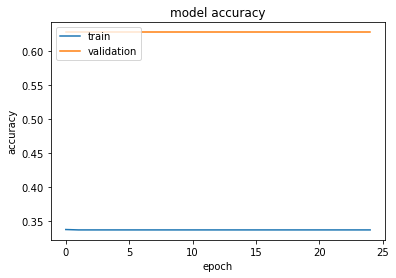

In [22]:
train_accuracy = []
val_accuracy = []
for accs in history_train_acc:
    train_accuracy.append(accs.avg)
for accs in history_val_acc:
    val_accuracy.append(accs.avg)
plt.plot(range(n_epoch),train_accuracy)
plt.plot(range(n_epoch),val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

## Some develop stuff

In [23]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print("y actual:",y)
    print(outputs.argmax(dim=1, keepdim=True).view(-1))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

y actual: tensor([2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Test Acc: 0.6875
y actual: tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Test Acc: 0.6875
y actual: tensor([0, 0, 2, 0, 0, 0, 0, 0, 1,

In [24]:
img, label = train_dataset.__getitem__(1700)

In [25]:
img

tensor([[[0.3922, 0.3922, 0.4078,  ..., 0.3765, 0.3765, 0.3765],
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         ...,
         [0.6039, 0.6039, 0.6627,  ..., 0.8275, 0.8275, 0.8275],
         [0.6039, 0.6039, 0.6627,  ..., 0.8275, 0.8275, 0.8431],
         [0.6196, 0.6196, 0.6627,  ..., 0.8275, 0.8275, 0.8431]],

        [[0.5529, 0.5529, 0.5059,  ..., 0.6000, 0.7059, 0.7059],
         [0.6902, 0.6902, 0.6275,  ..., 0.6392, 0.6392, 0.6392],
         [0.6902, 0.6902, 0.6275,  ..., 0.6392, 0.6392, 0.7725],
         ...,
         [0.4353, 0.4353, 0.4745,  ..., 0.5804, 0.5804, 0.5804],
         [0.4353, 0.4353, 0.4745,  ..., 0.5804, 0.5804, 0.6039],
         [0.4549, 0.4549, 0.4824,  ..., 0.5804, 0.5804, 0.6039]],

        [[0.5725, 0.5725, 0.5333,  ..., 0.6196, 0.7176, 0.7176],
         [0.6902, 0.6902, 0.6314,  ..., 0.6431, 0.6431, 0.6431],
         [0.6902, 0.6902, 0.6314,  ..., 0.6431, 0.6431, 0.

In [26]:
#with open("train/severe_HS_H08_20180124_0400_33.98652512_104.272.npy.pickle", 'rb') as f:
#    color_img = pickle.load(f)

In [27]:
# img = torch.tensor(color_img)
# img = img.permute(1,2,0)
# img = img/255
# img.shape

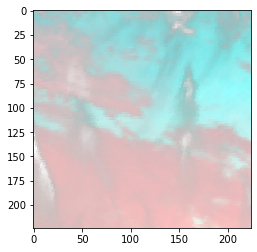

In [28]:
plt.imshow(img.permute(1,2,0))